## Load the required Libraries

In [ ]:
# Load required Libraries
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score


## Load and Read Dataset

In [121]:
# Load & Read Dataset
df= pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [123]:
df = df.drop(columns='id',axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


# **EDA**

In [124]:
features = df.columns
features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [125]:
Numerical_columns = [feature for feature in features if df[feature].dtypes !='O']
Categorical_columns = [feature for feature in features if df[feature].dtypes =='O']


In [126]:

corr = df[Numerical_columns].corr().round(2)
corr


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.17,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.18,0.13
bmi,0.33,0.17,0.04,0.18,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


<Axes: >

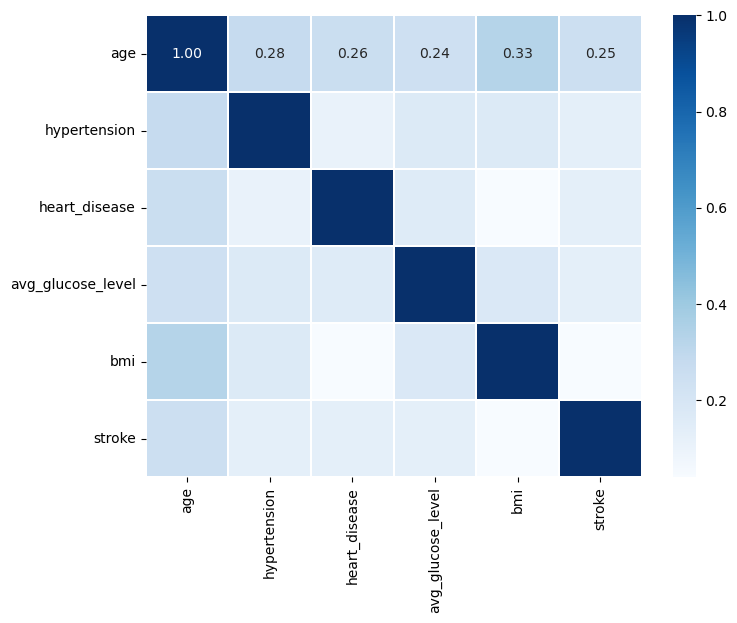

In [127]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt= '.2f',cmap= 'Blues',linewidths= 0.1)


In [128]:
df.stroke.unique()# CHECKING TARGET VARIABLE

array([1, 0], dtype=int64)

In [129]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

AN IMBALANCED DATASET 

<Axes: xlabel='stroke', ylabel='count'>

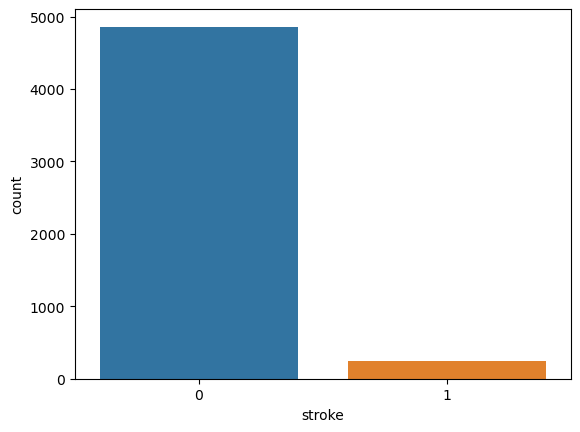

In [130]:
sns.countplot(x = df.stroke)

(0.0, 1.0, 0.0, 1.0)

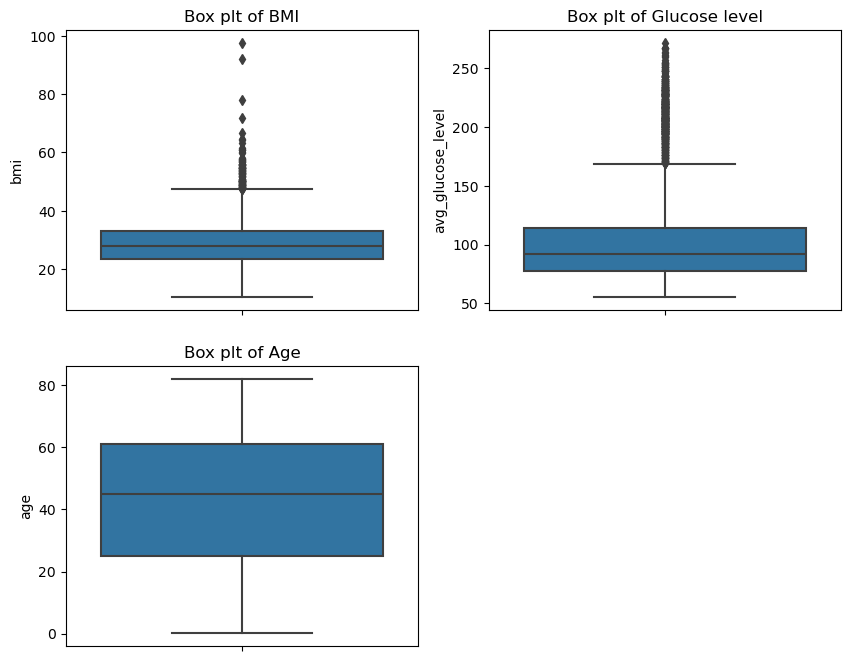

In [131]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.boxplot(y= df['bmi'], ax=ax1)
ax1.set_title('Box plt of BMI')
sns.boxplot(y= df['avg_glucose_level'], ax=ax2)
ax2.set_title('Box plt of Glucose level')
sns.boxplot(y=df['age'], ax=ax3)
ax3.set_title('Box plt of Age')

ax4.axis('off')

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

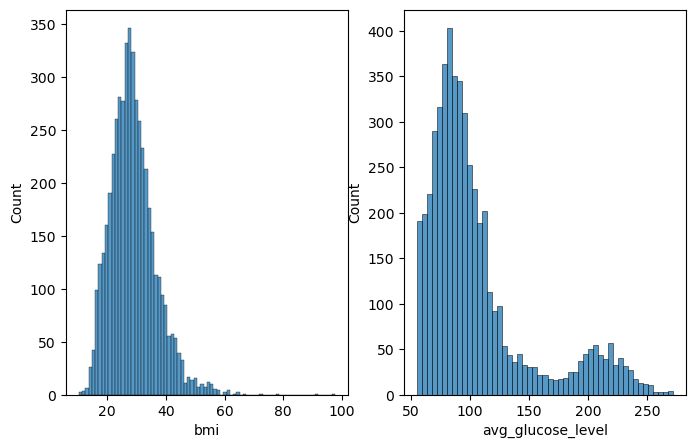

In [132]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
sns.histplot(x ='bmi', data= df, ax=ax1)
sns.histplot(x= 'avg_glucose_level', data= df, ax= ax2)


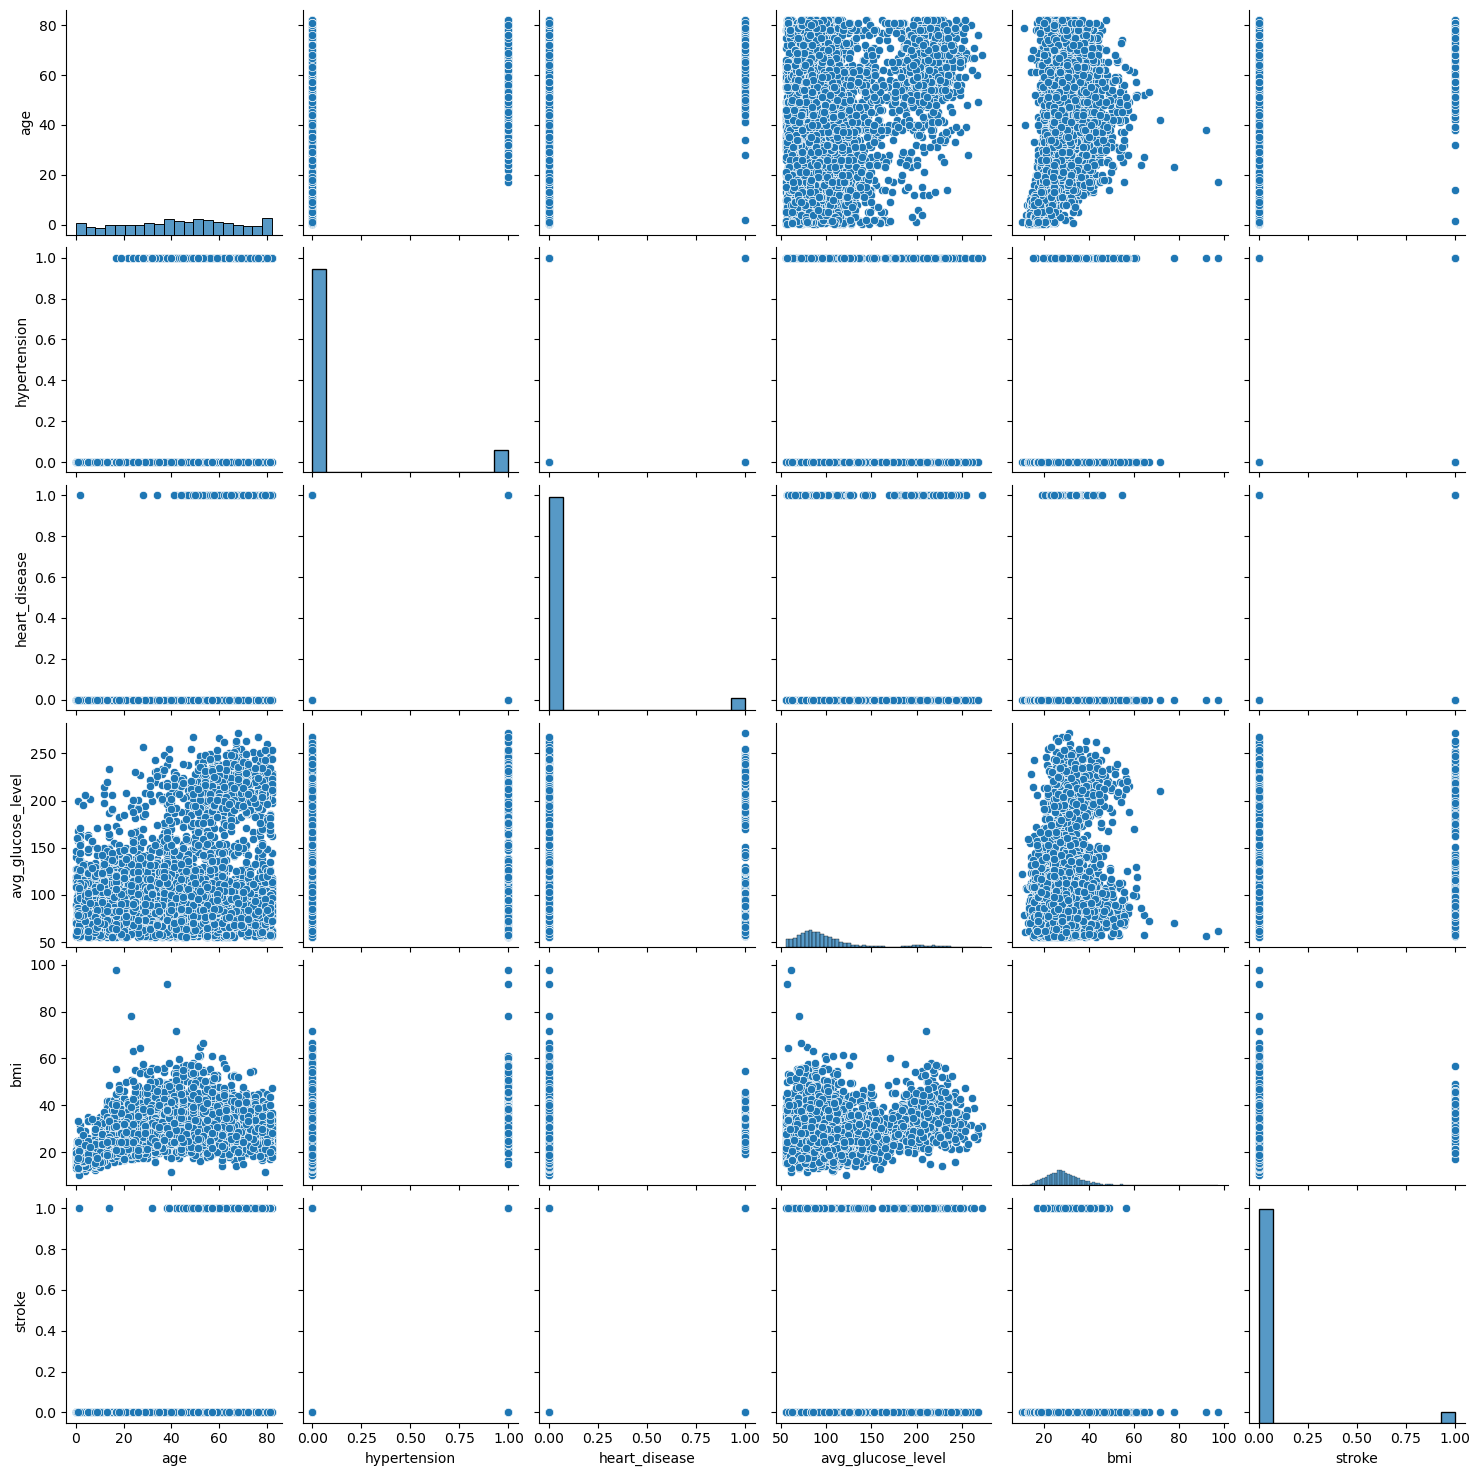

In [133]:
sns.pairplot(df[Numerical_columns])

### CATEGORICAL FEATURES

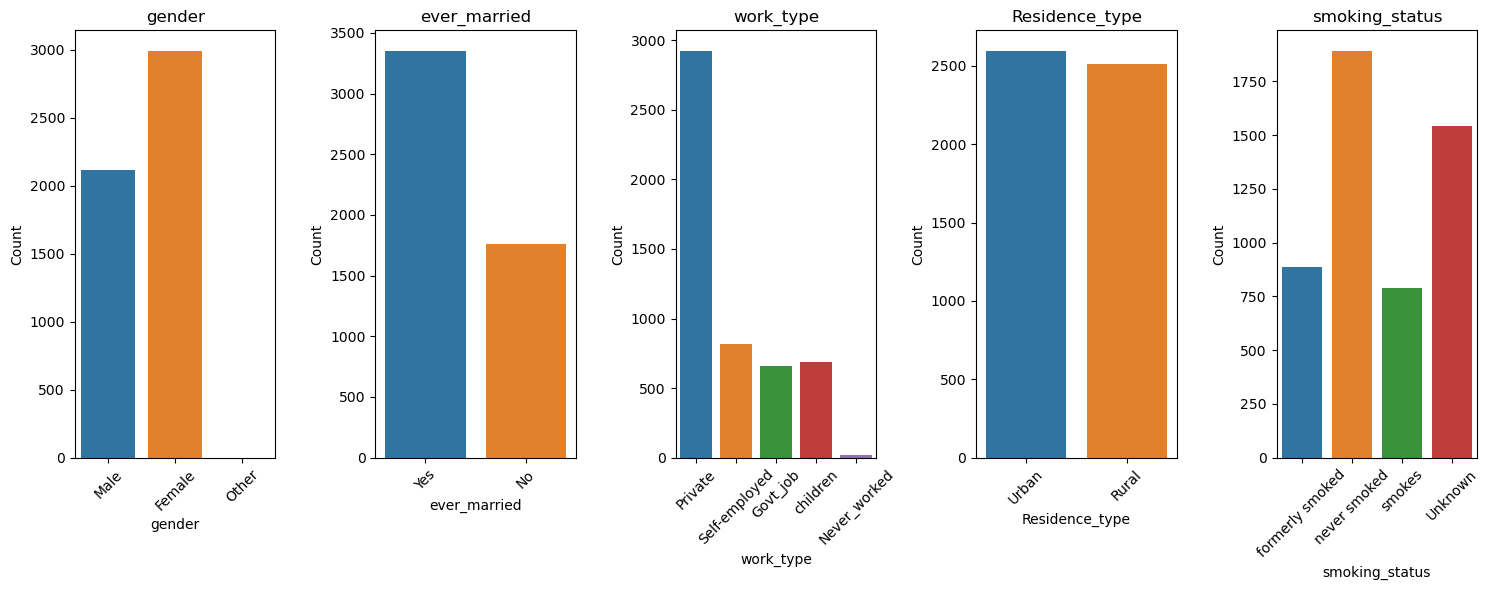

In [134]:
num_features = len(Categorical_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 6))

for i, feature in enumerate(Categorical_columns):
    sns.countplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

# **PREPROCESSING**

## Handling Missing/NA values


In [135]:
# Check for Missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We have 201 null values in the column bmi, so we need do imputation technique 

In [136]:
#IMPUTE MISSING VALUE WITH MEAN 
bmi_mean = df['bmi'].mean()
df.bmi = df['bmi'].fillna(bmi_mean)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


## Duplicates

In [137]:
# CHECK FOR DUPLICATE
df.duplicated().sum()

0

No duplicates found

## Handling Outliers

In [138]:
# Handling Outliers
numerical_columns_excluding_binary_age = [col for col in Numerical_columns if col not in ['hypertension', 'heart_disease', 'stroke', 'age']]
print(numerical_columns_excluding_binary_age)
Q1 = df[numerical_columns_excluding_binary_age].quantile(0.25)
Q3 = df[numerical_columns_excluding_binary_age].quantile(0.75)
print(Q1)
print(Q3)
IQR = Q3 - Q1
print(IQR)


['avg_glucose_level', 'bmi']
avg_glucose_level   77.25
bmi                 23.80
Name: 0.25, dtype: float64
avg_glucose_level   114.09
bmi                  32.80
Name: 0.75, dtype: float64
avg_glucose_level   36.84
bmi                  9.00
dtype: float64


In [139]:
df = df[~((df[numerical_columns_excluding_binary_age] < (Q1 - 1.5 * IQR)) |(df[numerical_columns_excluding_binary_age] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
1,Male,74.00,1,1,Yes,Private,Rural,70.09,27.40,never smoked,1
2,Female,69.00,0,0,No,Private,Urban,94.39,22.80,never smoked,1
3,Female,59.00,0,0,Yes,Private,Rural,76.15,28.89,Unknown,1
4,Female,78.00,0,0,Yes,Private,Urban,58.57,24.20,Unknown,1


## Feature Engineering


In [140]:
# Define function to map BMI to categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Apply function to create new feature
df['bmi_category'] = df['bmi'].apply(categorize_bmi)

In [141]:
new_features = df.columns
new_features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_category'],
      dtype='object')

## Feature Encoding

In [142]:
#Label Encoding 
Categorical_column = [feature for feature in new_features if df[feature].dtype =='O']
encoding = LabelEncoder()

for column in Categorical_column:
     df[column + '_encoded'] = encoding.fit_transform(df[column])
    
df.drop(columns=Categorical_column, inplace=True)

In [143]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded
0,80.00,0,1,105.92,32.50,1,1,1,2,0,2,1
1,74.00,1,1,70.09,27.40,1,1,1,2,0,2,2
2,69.00,0,0,94.39,22.80,1,0,0,2,1,2,0
3,59.00,0,0,76.15,28.89,1,0,1,2,0,0,2
4,78.00,0,0,58.57,24.20,1,0,1,2,1,0,0


In [144]:
# Add the 'stroke' column to the end
stroke_column = df.pop('stroke')
df['stroke'] = stroke_column


In [145]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded,stroke
0,80.00,0,1,105.92,32.50,1,1,2,0,2,1,1
1,74.00,1,1,70.09,27.40,1,1,2,0,2,2,1
2,69.00,0,0,94.39,22.80,0,0,2,1,2,0,1
3,59.00,0,0,76.15,28.89,0,1,2,0,0,2,1
4,78.00,0,0,58.57,24.20,0,1,2,1,0,0,1


In [146]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded,stroke
count,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00,4391.00
mean,40.90,0.07,0.04,91.48,27.81,0.41,0.62,2.20,0.51,1.35,1.20,0.04
std,22.54,0.26,0.19,22.66,6.56,0.49,0.48,1.11,0.50,1.09,0.92,0.19
min,0.08,0.00,0.00,55.12,11.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,23.00,0.00,0.00,75.07,23.20,0.00,0.00,2.00,0.00,0.00,0.00,0.00
50%,42.00,0.00,0.00,88.04,27.60,0.00,1.00,2.00,1.00,2.00,1.00,0.00
75%,58.00,0.00,0.00,104.02,31.90,1.00,1.00,3.00,1.00,2.00,2.00,0.00
max,82.00,1.00,1.00,168.68,46.20,2.00,1.00,4.00,1.00,3.00,3.00,1.00


## Splitting Data Dependent and Independent Variables

In [148]:
#Independent and dependent columns
X = df.drop(columns='stroke')
y = df['stroke']

## Handling Imbalance Data

In [149]:
# TO OVERCOME IMBALANCED DATASET
from imblearn.over_sampling import SMOTE

smote= SMOTE()
x1,y1 =smote.fit_resample(X,y)
print(x1.shape)
print(y1.shape)

(8452, 11)
(8452,)


## Normalization

In [151]:
standard_scaler =StandardScaler()
X_scaled =standard_scaler.fit_transform(x1)

# **MODEL BUILDING**

In [74]:
#Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1,train_size=0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6761, 11)
(1691, 11)
(6761,)
(1691,)


In [75]:
#Build model
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [76]:
y_pred = lr.predict(X_test)

In [77]:
accuracy =accuracy_score(y_test,y_pred)
accuracy

0.8285038438793614

In [79]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.83      0.82      0.82       833
           1       0.83      0.84      0.83       858

    accuracy                           0.83      1691
   macro avg       0.83      0.83      0.83      1691
weighted avg       0.83      0.83      0.83      1691



In [80]:
print(confusion_matrix(y_test,y_pred))

[[681 152]
 [138 720]]


In [81]:
Dt= DecisionTreeClassifier()
Dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [82]:
y_pred = Dt.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
accuracy

0.9178001182732111

In [83]:
print(classification_report(y_test,y_pred,zero_division = 1))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       833
           1       0.91      0.93      0.92       858

    accuracy                           0.92      1691
   macro avg       0.92      0.92      0.92      1691
weighted avg       0.92      0.92      0.92      1691



In [84]:
print(confusion_matrix(y_test,y_pred))

[[754  79]
 [ 60 798]]


In [85]:
rf =RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [86]:
y_pred= rf.predict(X_test)

In [87]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.9580130100532229

In [88]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       832
           1       0.96      0.96      0.96       859

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691



In [89]:
print(confusion_matrix(y_pred, y_test))

[[797  35]
 [ 36 823]]


In [90]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [91]:
y_pred = svm.predict(X_test)

In [92]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.8923713778829095

In [93]:
print(classification_report(y_pred, y_test,zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       791
           1       0.92      0.88      0.90       900

    accuracy                           0.89      1691
   macro avg       0.89      0.89      0.89      1691
weighted avg       0.89      0.89      0.89      1691



In [94]:
print(confusion_matrix(y_pred, y_test))

[[721  70]
 [112 788]]


In [95]:
naive_bais = GaussianNB()
naive_bais.fit(X_train, y_train)

GaussianNB()

In [96]:
y_pred = naive_bais.predict(X_test)

In [97]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.8285038438793614

In [98]:
print(classification_report(y_pred, y_test,zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.87      0.81       733
           1       0.89      0.80      0.84       958

    accuracy                           0.83      1691
   macro avg       0.83      0.83      0.83      1691
weighted avg       0.84      0.83      0.83      1691



In [99]:
print(confusion_matrix(y_pred, y_test))

[[638  95]
 [195 763]]


In [108]:
log_reg_model = LogisticRegression()
Decision_tree_model = DecisionTreeClassifier()
Random_forest_model = RandomForestClassifier()
naive_bais_model =GaussianNB()
svm_model = SVC()
KNN_model =KNeighborsClassifier()


In [109]:
model_list = [log_reg_model, Decision_tree_model, Random_forest_model,naive_bais_model, svm_model, KNN_model]
accuracy_list =[]
model_name = []
for model in model_list:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    Accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(Accuracy)
    model_name.append(model.__class__.__name__)



In [112]:
model_df= pd.DataFrame({'Model':model_name, 'Accuracy':accuracy_list})
model_df

,Model,Accuracy
0,LogisticRegression,0.83
1,DecisionTreeClassifier,0.92
2,RandomForestClassifier,0.96
3,GaussianNB,0.83
4,SVC,0.89
5,KNeighborsClassifier,0.90


# Model Validation

In [118]:
model_list = [log_reg_model, Decision_tree_model, Random_forest_model,naive_bais_model, svm_model, KNN_model]

CV = 5
accuracy_list =[]
model_name = []
for model in model_list:
    accuracy_cv = cross_val_score(model,X_scaled,y1,scoring= 'accuracy',cv=CV)
    accuracy = accuracy_cv.mean()
    accuracy_list.append(accuracy)
    model_name.append(model.__class__.__name__)



In [119]:
model_df_cv= pd.DataFrame({'Model':model_name, 'Accuracy':accuracy_list})
model_df_cv

,Model,Accuracy
0,LogisticRegression,0.81
1,DecisionTreeClassifier,0.92
2,RandomForestClassifier,0.96
3,GaussianNB,0.81
4,SVC,0.88
5,KNeighborsClassifier,0.90
